# 第一部分：匯入資料、計算

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as solver
import datetime as dt

route = input('Enter your file path: ')

try:
    database = pd.read_csv(route)
except UnicodeDecodeError: 
    database = pd.read_csv(route ,encoding='big5hkscs')

database.set_index("Date", inplace=True)
tickers = database.columns.tolist()
q = len(tickers)
#加這行
database = database[:'2017-05-12']

records = []
for i in tickers:
    records.append(len(database[i].dropna()))
records = min(records)

Enter your file path: /Users/Kang/Desktop/data.csv


In [98]:
returns = np.log(database / database.shift(1))

In [99]:
returns = returns.tail(records - 1)
returns.fillna(value=0, inplace=True)
print (returns.head())
print (returns.tail())

                AAPL        FB      GOOG      MSFT
Date                                              
2012-05-21  0.056626 -0.116378  0.022578  0.016266
2012-05-22 -0.007708 -0.093255 -0.021912  0.000336
2012-05-23  0.024107  0.031749  0.014311 -0.022083
2012-05-24 -0.009227  0.031680 -0.009562 -0.001375
2012-05-25 -0.005374 -0.034497 -0.020299 -0.000344
                AAPL        FB      GOOG      MSFT
Date                                              
2017-05-08  0.026825  0.005443  0.007704 -0.000870
2017-05-09  0.006384 -0.003847 -0.002282  0.001450
2017-05-10 -0.004752 -0.001263 -0.003643  0.003903
2017-05-11  0.008611 -0.001665  0.001958 -0.012340
2017-05-12  0.013869  0.001931  0.001739 -0.001169


In [100]:
returns = returns.fillna(value=0)

In [101]:
mean = returns.mean() * 252
cov = returns.cov() * 252
print (mean)
print (cov)

AAPL    0.221508
FB      0.275372
GOOG    0.229194
MSFT    0.197116
dtype: float64
          AAPL        FB      GOOG      MSFT
AAPL  0.065084  0.019965  0.017746  0.019406
FB    0.019965  0.145224  0.028975  0.019541
GOOG  0.017746  0.028975  0.049943  0.024005
MSFT  0.019406  0.019541  0.024005  0.052169


In [102]:
w = np.random.rand(q)
w /= sum(w)
w

array([0.06176769, 0.6279474 , 0.23644444, 0.07384048])

In [103]:
from functools import reduce
r = sum(w * mean) # multiply
s = np.sqrt(reduce(np.dot, [w, cov, w.T])) # dot multiply

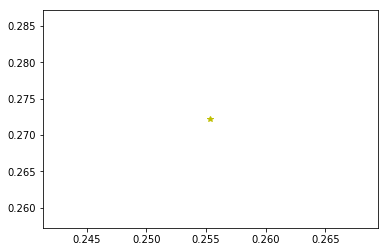

In [104]:
plt.plot(r, s, 'y*')

# 第二部分：蒙地卡羅

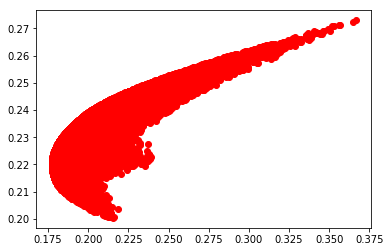

In [105]:
sds = []
rtn = []

for _ in range(100000):
    w = np.random.rand(q)
    w /= sum(w)
    rtn.append(sum(mean * w))
    sds.append(np.sqrt(reduce(np.dot, [w, cov, w.T])))

plt.plot(sds, rtn, 'ro') # ro for red dot

# 第三部分(0)：測試

In [106]:
def sd(w):
    return np.sqrt(reduce(np.dot, [w, cov, w.T]))

x0 = np.array([1.0 / q for x in range(q)])
bounds = tuple((0, 1) for x in range(q))
constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1},
               {'type': 'eq', 'fun': lambda x: sum(x * mean) - .18}]

outcome = solver.minimize(sd, x0=x0, constraints=constraints, bounds=bounds)
print (outcome)

     fun: 0.22840623176310798
     jac: array([0.08496278, 0.0855517 , 0.10509644, 0.22840623])
 message: 'Optimization terminated successfully.'
    nfev: 172
     nit: 16
    njev: 12
  status: 0
 success: True
       x: array([1.08002211e-14, 3.41679553e-19, 2.66788178e-13, 1.00000000e+00])


In [107]:
print (sum(outcome.x * mean))

0.19711563563814835


# 第三部分：標出效率前緣

In [110]:
def sd(w):
    return np.sqrt(reduce(np.dot, [w, cov, w.T]))

x0 = np.array([1.0 / q for x in range(q)])
bounds = tuple((0, 1) for x in range(q))

given_r = np.arange(.16, .28, .005)
risk = []

for i in given_r:
    constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: sum(x * mean) - i}]
    outcome = solver.minimize(sd, x0=x0, constraints=constraints, bounds=bounds)
    risk.append(outcome.fun)

Text(0, 0.5, 'portfolio return')

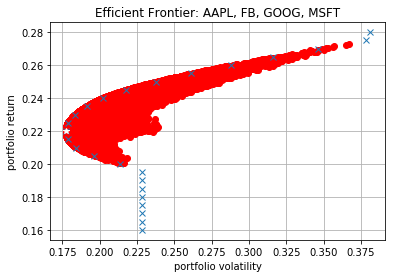

In [111]:
plt.plot(sds, rtn, 'ro')
plt.plot(risk, given_r, 'x')

constraints = {'type': 'eq', 'fun': lambda x: sum(x) - 1}
minv = solver.minimize(sd, x0=x0, constraints=constraints, bounds=bounds).fun
minvr = sum(solver.minimize(sd, x0=x0, constraints=constraints, bounds=bounds).x * mean)
plt.plot(minv, minvr, 'w*') # w* for white star

plt.grid(True)
plt.title('Efficient Frontier: AAPL, FB, GOOG, MSFT')
plt.xlabel('portfolio volatility')
plt.ylabel('portfolio return')

In [ ]:
#https://www.jianshu.com/p/306bc75a70ed